# 실습: kaggle Mercari Price Sugestion Challenge

## 데이터 불러오기

In [1]:
import pandas as pd
import numpy as np

In [4]:
train_df = pd.read_table('./필요 데이터/Mercari_Price_Suggestion_Challenge/train.tsv')
train_df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


- train_id: 아이디
- name: 제품명
- item_condition_id: 판매자가 제공하는 제품 상태
- category_name: 제품 카테고리
- brand_name: 브랜드 이름
- price: 가격    ------> 예측 TARGET 값
- shipping: 배송비 무료 여부(1은 무료(판매자 지불), 0은 유료)
- item_description: 제품에 대한 설명

- 비정형 데이터인 item_description 등을 이용해서 price 값을 예측하는 회귀 실습을 해볼 것

## EDA

#### NULL값 확인

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482531 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB


- 제품 카테고리, 브랜드이름이 NULL인 경우 존재

#### PRICE 분포 확인

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style = 'darkgrid')

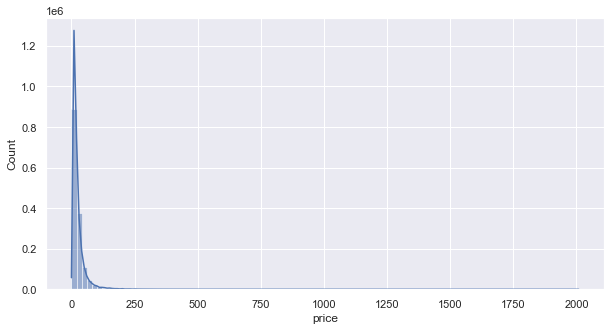

In [12]:
# PRICE 분포 확인

plt.figure(figsize = (10, 5))

sns.histplot(train_df['price'], bins = 100, kde = True)

plt.show()

- target 데이터인데 비교적 작은값으로 쏠려있는 경향이 있음 
    -> 로그변환해보겠음

In [13]:
import numpy as np

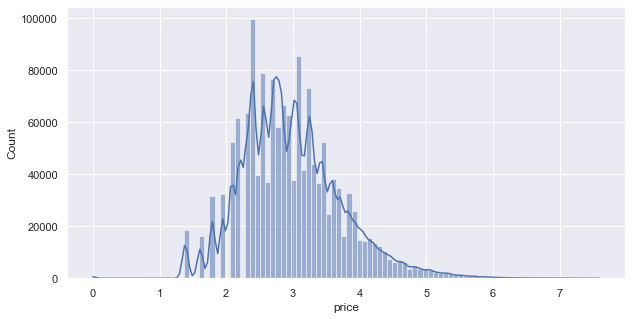

In [15]:
# PRICE 로그지수 변환


plt.figure(figsize = (10, 5))

sns.histplot(np.log1p(train_df['price']), bins = 100, kde = True)

plt.show()

- 정규분포와 비슷하게 분포하게 됨 -> 원본 데이터의 price도 로그변환하겠음

In [18]:
display(train_df.head(3))

# 로그변환
train_df['price'] = np.log1p(train_df['price'])


display(train_df.head(3))

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,2.397895,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,3.970292,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,2.397895,1,Adorable top with a hint of lace and a key hol...


#### 범주형 변수들 value 확인

In [19]:
train_df['item_condition_id'].value_counts()

1    640549
3    432161
2    375479
4     31962
5      2384
Name: item_condition_id, dtype: int64

In [20]:
train_df['shipping'].value_counts()

0    819435
1    663100
Name: shipping, dtype: int64

#### Item Description 

In [23]:
train_df[train_df['item_description'] == 'No description yet']['item_description'].count()

82489

- No description yet 이라 써있는 무의미한 설명이 8만건이 넘음
- 적절하게 변경해줘야 함

#### Category Name

In [25]:
train_df['category_name'].value_counts()

Women/Athletic Apparel/Pants, Tights, Leggings    60177
Women/Tops & Blouses/T-Shirts                     46380
Beauty/Makeup/Face                                34335
Beauty/Makeup/Lips                                29910
Electronics/Video Games & Consoles/Games          26557
                                                  ...  
Handmade/Dolls and Miniatures/Primitive               1
Handmade/Pets/Tag                                     1
Handmade/Patterns/Accessories                         1
Home/Kids' Home Store/Nursery Furniture               1
Handmade/Pets/Blanket                                 1
Name: category_name, Length: 1287, dtype: int64

In [32]:
train_df['category_num'] = train_df['category_name'].apply(lambda x: str(x).count('/'))
train_df['category_num'].value_counts()

2    1471819
0       6327
4       3059
3       1330
Name: category_num, dtype: int64

In [33]:
train_df[train_df['category_num'] == 4]

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,category_num
239,239,Zagg invisible shield for IPad air,1,Electronics/Computers & Tablets/iPad/Tablet/eB...,NaN,2.397895,1,Zag invisible shield for IPad air,4
742,742,iPad Pro Smart Cover,2,Electronics/Computers & Tablets/iPad/Tablet/eB...,NaN,3.465736,0,iPad Pro Smart Cover in Lilac Made for iPad Pr...,4
1700,1700,LIKE NEW KOBO eReader Tablet Only [rm]!!,1,Electronics/Computers & Tablets/iPad/Tablet/eB...,NaN,3.465736,0,Selling a tablet literally like new. No scratc...,4
2923,2923,Vuru tablet. 7 inch.,3,Electronics/Computers & Tablets/iPad/Tablet/eB...,NaN,3.295837,0,Vuru tablet. Perfect for children. It does hav...,4
3394,3394,iPod 1st generation 80gb,5,Electronics/Computers & Tablets/iPad/Tablet/eB...,Apple,3.044522,1,For parts or repair,4
...,...,...,...,...,...,...,...,...,...
1480808,1480808,Coach iPad case,3,Electronics/Computers & Tablets/iPad/Tablet/eB...,NaN,3.688879,0,Good condition,4
1481238,1481238,Kindle,2,Electronics/Computers & Tablets/iPad/Tablet/eB...,AmazonBasics,3.218876,0,No description yet,4
1481848,1481848,Samsung Tab 3,2,Electronics/Computers & Tablets/iPad/Tablet/eB...,Samsung,3.583519,1,Hardly ever used. No damage still has screen p...,4
1482283,1482283,Kindle Fire HD,3,Electronics/Computers & Tablets/iPad/Tablet/eB...,AmazonBasics,3.951244,0,This is a Kindle Fire HD. This is 7 inches. Wi...,4


- 카테고리를 '/'를 기준으로 대, 중, 소로 나눠보겠음

In [36]:
# '/' 기준으로 텍스트를 나누는 사용자함수 생성
def split_cat(x):
    try:
        return x.split('/')
    except:
        return ['Other_Null', 'Other_Null', 'Other_Null']
    

In [37]:
train_df['cat_dae'], train_df['cat_joong'], train_df['cat_so'] = zip(*train_df['category_name'].apply(lambda x: split_cat(x)))
train_df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,category_num,cat_dae,cat_joong,cat_so
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,2.397895,1,No description yet,2,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,3.970292,0,This keyboard is in great condition and works ...,2,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,2.397895,1,Adorable top with a hint of lace and a key hol...,2,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,3.583519,1,New with tags. Leather horses. Retail for [rm]...,2,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,3.806662,0,Complete with certificate of authenticity,2,Women,Jewelry,Necklaces


In [40]:
train_df['cat_dae'].value_counts()

Women                     664385
Beauty                    207828
Kids                      171689
Electronics               122690
Men                        93680
Home                       67871
Vintage & Collectibles     46530
Other                      45351
Handmade                   30842
Sports & Outdoors          25342
Other_Null                  6327
Name: cat_dae, dtype: int64

In [41]:
train_df['cat_joong'].value_counts()

Athletic Apparel        134383
Makeup                  124624
Tops & Blouses          106960
Shoes                   100452
Jewelry                  61763
                         ...  
Candles                     64
Ceramics and Pottery        57
Dolls and Miniatures        49
Books and Zines             46
Quilts                      31
Name: cat_joong, Length: 114, dtype: int64

In [42]:
train_df['cat_so'].value_counts()

Pants, Tights, Leggings       60177
Other                         50224
Face                          50171
T-Shirts                      46380
Shoes                         32168
                              ...  
Storage Solutions                 1
Map                               1
International Publications        1
St Patricks                       1
Ephemera                          1
Name: cat_so, Length: 871, dtype: int64

- <span style = 'background-color: #ffdce0'>zip(* 사용자함수)를 활용하면 생성된 리스트의 각 요소를 여러 개의 칼럼으로 간단하게 분리 가능</span>
- 카테고리 대, 중, 소를 나눔

#### NULL 값 채우기
- 카테고리 대, 중, 소에 채웠듯이 NULL값을 'Other Null'로 채우겠음

In [45]:
train_df.isnull().sum()

train_id                  0
name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          4
category_num              0
cat_dae                   0
cat_joong                 0
cat_so                    0
dtype: int64

In [46]:
train_df['brand_name'] = train_df['brand_name'].fillna( 'Other Null')
train_df['category_name'] = train_df['category_name'].fillna( 'Other Null')
train_df['item_description'] = train_df['item_description'].fillna( 'Other Null')

In [47]:
train_df.isnull().sum()

train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
category_num         0
cat_dae              0
cat_joong            0
cat_so               0
dtype: int64

In [48]:
train_df.drop('category_num', axis = 1, inplace = True)

## 피처벡터화
- price를 예측하는 회귀모델링이고, 선형회귀의 경우 범주형 변수를 원-핫 인코딩이 선호됨
- 비교적 짧은 텍스트는 Count 기반 벡터화, 긴 텍스트는 TFIDF 기반 벡터화 적용하도록 함

#### Item Description 

In [60]:
# 평균 텍스트 길이 재보기

train_df['item_description'].str.len().mean()

145.7113889385411

- <span style = 'background-color: #f1f8ff'>TFIDF 기반 텍스트 벡터화 </span> 진행

#### Name

In [55]:
train_df['name'].nunique()

1225273

- 범주형자료이긴 하나, 전체 상품명이 1,225,273개나 될만큼 많이 존재함
- 따라서 원-핫 인코딩이 아닌 <span style = 'background-color: #f1f8ff'>Count 기반 텍스트 벡터화</span> 하겠음

In [61]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [62]:
count_vect = CountVectorizer()
name = count_vect.fit_transform(train_df['name'])


tfidf_vect = TfidfVectorizer(max_features = 50000, ngram_range = (1,3), stop_words = 'english')
description = tfidf_vect.fit_transform(train_df['item_description'])

In [63]:
name.shape, description.shape

((1482535, 105757), (1482535, 50000))

- 피처벡터화된 행렬은 <span style = 'background-color: #ffdce0'>희소행렬</span> 상태

## 원핫 인코딩

####  Brand Name

In [56]:
train_df['brand_name'].nunique()

4810

- 범주형 자료이고, 전체 브랜드 이름이 4810여개 됨
- 원핫인코딩을하기에 너무 많아보이지만, 이 실습 예제에서 ML 모델 구축 상 문제가 없다고 함
- 따라서, <span style = 'background-color: #f1f8ff'>원- 핫 인코딩</span> 진행

#### 카테고리 대, 중, 소

In [57]:
train_df['cat_so'].nunique(), train_df['cat_dae'].nunique(), train_df['cat_joong'].nunique()

(871, 11, 114)

- <span style = 'background-color: #f1f8ff'>원- 핫 인코딩</span> 진행

#### Shipping

In [58]:
train_df['shipping'].nunique()

2

- <span style = 'background-color: #f1f8ff'>원- 핫 인코딩</span> 진행

#### Item Condition

In [59]:
train_df['item_condition_id'].nunique()

5

- <span style = 'background-color: #f1f8ff'>원- 핫 인코딩</span> 진행

- 텍스트 컬럼을 벡터화하면 희소행렬로 변환됨
- 인코딩될 카테고리 대, 중, 소, 아이템품질, 배송무료여부, 브랜드 이름도 모두 피처 벡터화된 행렬과 결합되어 ML 모델을 실행하는 데이터셋으로 재구성되어야 함
<br>
- 따라서,<span style = 'background-color: #ffdce0'>원핫인코딩될 컬럼들을 밀집행렬 형태가 아니라, 희소행렬 형태로 인코딩을 적용한 뒤 결합</span>하도록 함!

- <span style = 'background-color: #ffdce0'><b>원핫인코딩에는 OneHotEncoder의 LabelBinarizer 클래스를 활용 </b>
    - <b>sparse_output = True로 파라미터 설정</b>해주면 됨</span>
    - sparse_output = False로 했더니 메모리 에러났음ㅎㅎ

In [65]:
from sklearn.preprocessing import LabelBinarizer

In [67]:
# 브랜드이름
lb_brand_name = LabelBinarizer(sparse_output = True)
brand_name = lb_brand_name.fit_transform(train_df['brand_name'])

# 아이템 품질
lb_item_condition_id = LabelBinarizer(sparse_output = True)
item_condition_id = lb_item_condition_id.fit_transform(train_df['item_condition_id'])

# 무료배송 여부
lb_shipping = LabelBinarizer(sparse_output = True)
shipping = lb_shipping.fit_transform(train_df['shipping'])


# 카테고리
lb_cat_dae = LabelBinarizer(sparse_output = True)
cat_dae = lb_cat_dae.fit_transform(train_df['cat_dae'])

lb_cat_joong = LabelBinarizer(sparse_output = True)
cat_joong = lb_cat_joong.fit_transform(train_df['cat_joong'])

lb_cat_so = LabelBinarizer(sparse_output = True)
cat_so = lb_cat_so.fit_transform(train_df['cat_so'])  

In [71]:
brand_name.shape

(1482535, 4810)

In [72]:
from scipy.sparse import hstack
import gc

In [74]:
# 변환된 컬럼 합치기

sparse_matrix_list = (name, description,
                      brand_name, item_condition_id, shipping, 
                      cat_dae, cat_joong, cat_so)

X_features_sparse = hstack(sparse_matrix_list).tocsr()

# csr 형식의 희소행렬임
print(type(X_features_sparse), X_features_sparse.shape)


# 결합 데이터는 많은 용량을 차지하고, 모델에 데이터셋을 적용할 때 다양한 조합으로 적용할 예정
# 이므로 삭제하도록함.
del X_features_sparse
gc.collect()

<class 'scipy.sparse.csr.csr_matrix'> (1482535, 161569)


3618

### 릿지 회귀모델 구축 및 평가
- 모델 평가는 rmsle(Root Mean Square Logarithmic Error)방식으로 진행
    - RMSLE는 RMSE와 유사하나 오류 값에 로그를 취해 RMSE를 구하는 방식임
    - 낮은 가격보다 높은 가격에서 오류가 발생할 경우 오류값이 더 커지는 것을 억제하기 위해 도입함
    
- 주의할 점은, PRICE 데이터의 왜곡이 심해서 로그변환을 시켰다는 점임.
- 예측도 로그변환된 형태로 나오기 때문에 지수로 역변환하는 과정이 필요함

In [103]:
def rmsle(y, y_pred):
    return np.sqrt(np.mean(np.power(np.log1p(y) - np.log1p(y_pred),2)))

def evaluate_org_price(y_test, preds):
    preds_exmpm = np.expm1(preds)
    y_test_exmpm = np.expm1(y_test)
    
    rmsle_result = rmsle(y_test_exmpm, preds_exmpm)
    return rmsle_result

In [104]:
import gc
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split

In [105]:
def model_train_predict(model, matrix_list):
    X = hstack(matrix_list).tocsr()
    
    X_train, X_test, y_train, y_test = train_test_split(X, train_df['price'],
                                                        test_size = 0.2,
                                                        random_state = 156)
    
    model.fit(X_train, y_train)
    
    preds = model.predict(X_test)
    
    del X, X_train, y_train, X_test,
    gc.collect()
    
    return preds, y_test

In [106]:
from sklearn.linear_model import Ridge

In [109]:
# description을 포함하지 않았을 때
ridge = Ridge(solver = 'lsqr', fit_intercept = False)

sparse_matrix_list = (name,
                      brand_name, item_condition_id, shipping, 
                      cat_dae, cat_joong, cat_so)

preds, y_test = model_train_predict(ridge, sparse_matrix_list)
print(evaluate_org_price(y_test, preds))


# description을 포함했을 때
ridge = Ridge(solver = 'lsqr', fit_intercept = False)

sparse_matrix_list = (name, description,
                      brand_name, item_condition_id, shipping, 
                      cat_dae, cat_joong, cat_so)

preds, y_test = model_train_predict(ridge, sparse_matrix_list)
print(evaluate_org_price(y_test, preds))

0.5017095679031606
0.4712217018820502


### LightGBM 회귀모델 구축과 앙상블

In [114]:
from lightgbm import LGBMRegressor

lgbm_model = LGBMRegressor(n_estimators = 300, 
                           learning_rate = 0.05, 
                           num_leaves = 125,
                           random_state = 156)

sparse_matrix_list = (name, description,
                      brand_name, item_condition_id, shipping, 
                      cat_dae, cat_joong, cat_so)

lgbm_preds, lgbm_y_test = model_train_predict(lgbm_model, sparse_matrix_list)
print(evaluate_org_price(lgbm_preds, lgbm_y_test))

0.48292474583971523


In [115]:
preds_ensemble = 0.45 * lgbm_preds + 0.55 * preds

print(evaluate_org_price(y_test, preds_ensemble))

0.4621422193230805
